<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Natural Language Processing

## LSTM Bot QA


### Datos

El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)


In [61]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [62]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [63]:
!pip3 install torchinfo
from torchinfo import summary

In [64]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [65]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [66]:
def sequence_acc(y_pred, y_test):
    y_pred_tag = y_pred.data.max(dim=-1, keepdim=True)[1]
    y_test_tag = y_test.data.max(dim=-1, keepdim=True)[1]

    batch_size = y_pred_tag.shape[0]
    batch_acc = torch.zeros(batch_size)
    for b in range(batch_size):
        correct_results_sum = (y_pred_tag[b] == y_test_tag[b]).sum().float()
        batch_acc[b] = correct_results_sum / y_pred_tag[b].shape[0]

    correct_results_sum = batch_acc.sum().float()
    acc = correct_results_sum / batch_size
    return acc


def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []
    valid_loss = []
    valid_accuracy = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_encoder_input, train_decoder_input, train_target in train_loader:
            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_encoder_input.to(device),
                           train_decoder_input.to(device))

            # Computo el error de la salida comparando contra las etiquetas
            # por cada token en cada batch (sequence_loss)
            loss = 0
            for t in range(train_decoder_input.shape[1]):
                loss += criterion(output[:, t, :], train_target[:, t, :])

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = sequence_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        # valid_encoder_input, valid_decoder_input, valid_target = iter(valid_loader).next()

        # valid_data, valid_target = iter(valid_loader).next()
        data_iter = iter(valid_loader)
        valid_encoder_input, valid_decoder_input, valid_target = next(
            data_iter)
        output = model(valid_encoder_input.to(device),
                       valid_decoder_input.to(device))

        epoch_valid_loss = 0
        for t in range(train_decoder_input.shape[1]):
            epoch_valid_loss += criterion(output[:, t, :],
                                          valid_target[:, t, :])
        epoch_valid_loss = epoch_valid_loss.item()

        valid_loss.append(epoch_valid_loss)

        # Calculo el accuracy de la epoch
        epoch_valid_accuracy = sequence_acc(output, valid_target).item()
        valid_accuracy.append(epoch_valid_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f} - Valid Loss {epoch_valid_loss:.3f} - Valid accuracy {epoch_valid_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
        "val_loss": valid_loss,
        "val_accuracy": valid_accuracy,
    }
    return history

### 1. Datos


In [67]:
# Download the dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [68]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f)  # the data variable will be a dictionary

In [69]:
# Observing the disponibles fields in every line of the dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [70]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30


def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt


for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Number of rows used:", len(input_sentences))

Number of rows used: 6033


In [71]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocessing

Realizar el preprocesamiento necesario para obtener:

- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets


In [72]:
# Define the maximun number of words
MAX_VOCABULARY_SIZE = 8000

In [73]:
from torch_helpers import Tokenizer


# Create tokenizer for the input text and fit it to them
tokenizer_inputs = Tokenizer(num_words=MAX_VOCABULARY_SIZE)
tokenizer_inputs.fit_on_texts(input_sentences)

# Tokenize and transform input texts to sequence of integers
input_integer_seq = tokenizer_inputs.texts_to_sequences(input_sentences)

In [74]:
word2idx_inputs = tokenizer_inputs.word_index
print('Words in the vocabulary', len(word2idx_inputs))

# Calculate the max length
max_input_len = max(len(sentence) for sentence in input_integer_seq)
print('The longest sentence', max_input_len)

Words in the vocabulary 1799
The longest sentence 9


In [75]:
# Check the tokenization
print(input_integer_seq[200])

[22]


In [76]:
# Create tokenizer for the outpu text and fit it to them
# output_tokenizer = Tokenizer(num_words=MAX_VOCABULARY_SIZE, filters='')
output_tokenizer = Tokenizer(
    num_words=MAX_VOCABULARY_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')

output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)

In [77]:
# Get the word to index mapping for output answer
word2idx_outputs = output_tokenizer.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 1806 unique output tokens.


In [78]:
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(
    output_sentences_inputs)

In [79]:
# Calculate the max length for the ouput
max_output_len = max(len(sentence) for sentence in output_integer_seq)
print('The longest sentence in the output', max_output_len)

The longest sentence in the output 10


In [80]:
# One is added to include the toke of unknown word
number_word_output = min(len(word2idx_outputs) + 1, MAX_VOCABULARY_SIZE)
print(number_word_output)

1807


In [81]:
from torch_helpers import pad_sequences

encoder_input_seq = pad_sequences(input_integer_seq, maxlen=max_input_len)
print('Encoder input sequences shape: ', encoder_input_seq.shape)

decoder_input_seq = pad_sequences(
    output_integer_seq, maxlen=max_output_len, padding='post')
print('Decoder input sequences shape: ', decoder_input_seq.shape)

Encoder input sequences shape:  (6033, 9)
Decoder input sequences shape:  (6033, 10)


In [82]:
max_output_len

10

In [83]:
# from keras.utils.np_utils import to_categorical
decoder_output_seq = pad_sequences(
    output_integer_seq, maxlen=max_output_len, padding='post')
decoder_output_seq.shape

torch.from_numpy(decoder_output_seq).shape

torch.Size([6033, 10])

In [84]:
decoder_output_seq.shape

(6033, 10)

In [85]:
class Data(Dataset):
    def __init__(self, encoder_input, decoder_input, decoder_output):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
        self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
        # Transformar los datos a oneHotEncoding
        # la loss function esperan la salida float
        self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(
            torch.int64), num_classes=number_word_output).float()

        self.len = self.decoder_outputs.shape[0]

    def __getitem__(self, index):
        return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

    def __len__(self):
        return self.len


data_set = Data(encoder_input_seq, decoder_input_seq, decoder_output_seq)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[2]
print("Output dim", output_dim)

encoder_input_size: 9
decoder_input_size: 10
Output dim 1807


In [86]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(
    data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=32, shuffle=False)

Tamaño del conjunto de entrenamiento: 4827
Tamaño del conjunto de validacion: 1206


### 3 - Preparing the embeddings

Using the embeddings of Glove or Fastext to transform the input tokens to vectors

Based on subject Natural Language Processing - University of Buenos Aires - Embedded Systems Laboratory


In [87]:
# Download the embeddings
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("The embeddings gloveembedding.pkl have been downloaded yet")

The embeddings gloveembedding.pkl have been downloaded yet


In [88]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle


class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dictionary to translate of the embeeding to word idx
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1  # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1  # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    # N_FEATURES = 51
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [89]:
model_embeddings = GloveEmbeddings()

In [90]:
# model_embeddings = FasttextEmbeddings()

In [91]:
# Making the matrix embedding of the sequences
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# The word index comes from tokenizer

nb_words = min(MAX_VOCABULARY_SIZE, len(word2idx_inputs))  # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(
    np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 38


In [92]:
# The embedding size
embedding_matrix.shape

(1799, 50)

In [93]:
nb_words

1799

In [94]:
embedding_matrix.shape

(1799, 50)

### 4 - Training the model

Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.


In [95]:
max_input_len

9

In [96]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        # marcar como layer no entrenable (freeze)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers)  # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)


class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        # num_embeddings = vocab_size, definido por le Tokenizador
        # embedding_dim = 50 --> dimensión de los embeddings utilizados
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers)  # LSTM layer
        # Fully connected layer
        self.fc1 = nn.Linear(in_features=self.lstm_size,
                             out_features=self.output_dim)

        self.softmax = nn.Softmax(dim=1)  # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # take last output (last seq)
        out = self.softmax(self.fc1(lstm_output[:, -1, :]))
        return out, (ht, ct)


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim

        # tensor para almacenar la salida
        # (batch_size, sentence_len, one_hot_size)
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)

        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            # t --> token index

            # utilizamos método "teacher forcing", es decir que durante
            # el entrenamiento no realimentamos la salida del decoder
            # sino el token correcto que sigue en target
            input = decoder_input[:, t:t+1]

            # ingresar cada token embedding, uno por uno junto al hidden state
            # recibir el output del decoder (softmax)
            output, prev_state = self.decoder(input, prev_state)
            top1 = output.argmax(1).view(-1, 1)

            # Sino se usará "teacher forcing" habría que descomentar
            # esta linea.
            # Hay ejemplos dandos vuelta en donde se utilza un random
            # para ver en cada vuelta que técnica se aplica
            # input = top1

            # guardar cada salida (softmax)
            outputs[:, t, :] = output

        return outputs


encoder = Encoder(vocab_size=nb_words)
if cuda:
    encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=number_word_output, output_dim=number_word_output)
if cuda:
    decoder.cuda()

model = Seq2Seq(encoder, decoder)
if cuda:
    model.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

summary(model, input_data=(data_set[0:1][0], data_set[0:1][1]))

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 10, 1807]             --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 9, 50]                (89,950)
│    └─LSTM: 2-2                         [1, 9, 128]               92,160
├─Decoder: 1-2                           [1, 1807]                 --
│    └─Embedding: 2-3                    [1, 1, 50]                90,350
│    └─LSTM: 2-4                         [1, 1, 128]               92,160
│    └─Linear: 2-5                       [1, 1807]                 233,103
│    └─Softmax: 2-6                      [1, 1807]                 --
├─Decoder: 1-3                           [1, 1807]                 (recursive)
│    └─Embedding: 2-7                    [1, 1, 50]                (recursive)
│    └─LSTM: 2-8                         [1, 1, 128]               (recursive)
│    └─Linear: 2-9                 

In [97]:
history1 = train(model,
                 train_loader,
                 valid_loader,
                 optimizer,
                 criterion,
                 epochs=20
                 )

Epoch: 1/20 - Train loss 67.211 - Train accuracy 0.782 - Valid Loss 67.035 - Valid accuracy 0.797
Epoch: 2/20 - Train loss 66.915 - Train accuracy 0.809 - Valid Loss 66.880 - Valid accuracy 0.812
Epoch: 3/20 - Train loss 66.867 - Train accuracy 0.814 - Valid Loss 66.789 - Valid accuracy 0.822
Epoch: 4/20 - Train loss 66.821 - Train accuracy 0.818 - Valid Loss 66.757 - Valid accuracy 0.825
Epoch: 5/20 - Train loss 66.790 - Train accuracy 0.821 - Valid Loss 66.724 - Valid accuracy 0.828
Epoch: 6/20 - Train loss 66.760 - Train accuracy 0.824 - Valid Loss 66.739 - Valid accuracy 0.825
Epoch: 7/20 - Train loss 66.741 - Train accuracy 0.826 - Valid Loss 66.723 - Valid accuracy 0.828
Epoch: 8/20 - Train loss 66.750 - Train accuracy 0.825 - Valid Loss 66.723 - Valid accuracy 0.828
Epoch: 9/20 - Train loss 66.745 - Train accuracy 0.826 - Valid Loss 66.722 - Valid accuracy 0.828
Epoch: 10/20 - Train loss 66.743 - Train accuracy 0.826 - Valid Loss 66.722 - Valid accuracy 0.828
Epoch: 11/20 - Trai

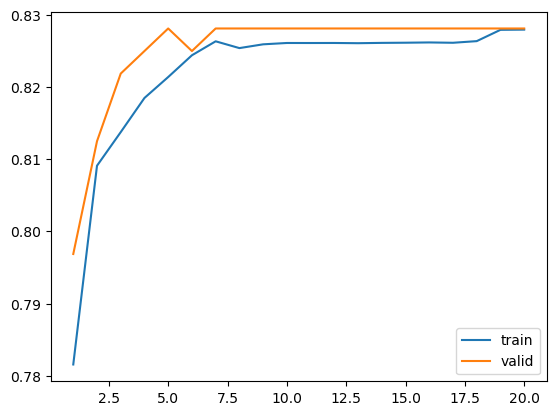

In [98]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

### 5 - Inference

Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.


In [99]:
# Based on the subject Natural Language Processing - Embedded Systems Laboratory - UBA

# Make the conversor from index to word:
idx2word_input = {v: k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [100]:
input_test = 'I am a clean eater'
print('Input: ', input_test)
integer_seq_test = tokenizer_inputs.texts_to_sequences([input_test])[0]
print('Vectorial representations of tokens of ids', integer_seq_test)
encoder_seq_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Vector padding", encoder_seq_test)
encoder_seq_test_tensor = torch.from_numpy(encoder_seq_test.astype(np.int32))

prev_state = model.encoder(encoder_seq_test_tensor.to(device))

# Initialize input sequence to the decoder as <sos>
target_seq = np.zeros((1, 1))
target_seq[0, 0] = word2idx_outputs['<sos>']
target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

output, prev_state = model.decoder(target_seq_tensor.to(device), prev_state)

top1 = output.argmax(1).view(-1, 1)
idx = int(top1.cpu())

word = idx2word_target[idx]
print("Word output", word)

Input:  I am a clean eater
Vectorial representations of tokens of ids [1, 9, 5]
Vector padding [[0 0 0 0 0 0 1 9 5]]
Word output for


In [104]:
def chat_bot_qa(input_seq):
    prev_state = model.encoder(encoder_seq_test_tensor.to(device))

    # Initialize input sequence to the decoder as <sos>
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    target_seq_tensor = torch.from_numpy(target_seq.astype(np.int32))

    eos = word2idx_outputs['<eos>']

    output_sentence = []
    
    for _ in range(max_output_len):
        # Prediction of the next element
        output, new_prev_state = model.decoder(
            target_seq_tensor.to(device), prev_state)
        top1 = output.argmax(1).view(-1, 1)
        idx = int(top1.cpu())

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transform idx to word
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dado la ultimo prediccion
        prev_state = new_prev_state

        # Actualizar secuencia de entrada con la salida (re-alimentacion)
        target_seq_tensor = top1

    return ' '.join(output_sentence)
    #return ','.join([str(s) for s in output_sentence])

In [105]:
for i in range(0,6):
    i = np.random.choice(len(input_sentences))
    input_seq = encoder_input_seq[i:i+1]
    encoder_sequence_test_tensor = torch.from_numpy(input_seq.astype(np.int32))
    chat_bot = chat_bot_qa(encoder_sequence_test_tensor)
    print('-')
    print('Input:', input_sentences[i])
    print('Response:', chat_bot)


-
Input: i love to read
Response: for for for for for for for for for for
-
Input: what do you do for a living 
Response: for for for for for for for for for for
-
Input: what do you do for a living 
Response: for for for for for for for for for for
-
Input: hi
Response: for for for for for for for for for for
-
Input: are you there 
Response: for for for for for for for for for for
-
Input: lol what is the best food 
Response: for for for for for for for for for for
